# Classify single image patches

Not expected to be very precise - more of a model structure search

In [1]:
import os
os.system("export MKL_NUM_THREADS=4")
os.system("export NUMEXPR_NUM_THREADS=4")
os.system("export OMP_NUM_THREADS=4")

0

In [2]:
import os
import sys
import numpy as np
import pandas as pd
from pyarrow import parquet

import skelm

from matplotlib import pyplot as plt, rcParams
%matplotlib inline
rcParams['figure.figsize'] = (15, 8)

# import seaborn as sns
# sns.set(rc={'figure.figsize':(15, 8)})

In [3]:
from multiprocessing import Pool

In [4]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [5]:
from sklearn.model_selection import GroupKFold, cross_val_score, GridSearchCV, GroupShuffleSplit, RandomizedSearchCV
import scipy
from sklearn.utils.fixes import loguniform
from time import time

In [6]:
overlap = '50p'
MAX_SAMPLES_PER_FILE = 30
# data_path = "/scratch/project_2001220/leonardo/00_Features/GPDSS10000/folder2/004/overlap" + overlap

# 

## Load data

In [7]:
data = np.load("data_200k.npy")

In [8]:
x = data[:, :-1]
y = data[:, -1]

In [9]:
m,s = x.mean(0), x.std(0)
x -= m
x /= s

In [10]:
x = np.ascontiguousarray(x)
y = np.ascontiguousarray(y)

#  

## Get ELM model

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
xt, xv, yt, yv = train_test_split(x, y, test_size=0.1)

In [15]:
model = skelm.ELMClassifier(alpha=0.1, ufunc='tanh', density=0.1, n_neurons=50)

In [16]:
%time model.fit(xt, yt)

CPU times: user 14.6 s, sys: 696 ms, total: 15.3 s
Wall time: 4.62 s


ELMClassifier(alpha=0.1, density=0.1, n_neurons=50)

In [17]:
model.score(xv, yv)

0.5719521604938271

# 

## MCYT test

1. Read all features from one image file
2. Predict on those features; average predictions
3. Save original file label with that prediction
4. Get EER and ROC curves
5. Compare a few models; including old "best features" model
6. GOTO experimental discovery of the new *best large ELM* model

In [ ]:
data_folder = "/Users/akusok/wrkdir/research-signatures-data/MCYTDB"
overlap = '50p'
samples = 10000000 // 30

data_file = "/Users/akusok/wrkdir/research-signatures-data/MCYTD_overlap{}_n200.pkl".format(overlap)

In [ ]:
def load_batch(j, loo=False):
    """Load batch `j` of `users` list, as Numpy array.
    
    loo (bool, default=False): whether to return single LOO file per user separately.
    """    
    data = X0[X0.uid.isin(users[j])]
    
    if loo:
        # get LOO split
        t = data.loc[:, 'uid':'fid']
        t = t.sample(frac=1.0, replace=False)
        fid_loo = t.groupby('uid').first()['fid']

        data_loo = data[data.fid.isin(fid_loo)]
        data = data[~data.fid.isin(fid_loo)]
        Y_loo = data_loo.loc[:, 'sig_true'].to_numpy()
        U_loo = data_loo.loc[:, 'uid']
        Z_loo = data_loo.loc[:, '0':'1023'].to_numpy()

    Y = data.loc[:, 'sig_true'].to_numpy()
    Z = data.loc[:, '0':'1023'].to_numpy()
    
    zm = Z.mean()
    zs = Z.std().clip(min=0.5)
    Z = (Z - zm) / zs
    Z = Z.clip(min=-5, max=5)

    if loo:
        Z_loo = (Z_loo - zm) / zs
        Z_loo = Z_loo.clip(min=-5, max=5)
        return Z, Y, Z_loo, Y_loo, U_loo
        
    return Z, Y

In [ ]:
res = []

for k in range(1,6):
    print(k)
    x, y, xv, yv, uv = load_batch(k, loo=True)
    
    model.add_data(x, y)
    model.nnet.solve()
    
    yh1 = model.predict(xv)
    yv1 = yv[:,None]
    res_k = pd.DataFrame(np.hstack((yv1, yh1)), index=uv).groupby('uid').mean()
    res.append(res_k)

In [25]:
ffake = "/Users/akusok/Dropbox/research-signatures/results-fakes-unsupervised/res{}.txt"

In [26]:
data = []

for i in range(99):
    with open(ffake.format(i+1), "r") as f:
        header = True
        lines = []

        for line in f:
            if line.startswith('uid'):
                header = False
            if header:
                continue

            if line.startswith('accuracy'):
                break

            lines.append(line.rstrip('\n'))

        lines = lines[1:]
        d0 = [[float(l) for l in line.split(' ') if len(l)>0] for line in lines]
        d1 = pd.DataFrame(d0)
        data.append(d1)
        
X = pd.concat(data, axis=0)

In [27]:
accuracy_score(X[1]>0.5, X[2]>0.5)

0.6703030303030303

In [28]:
fprU, tprU, thresholds = roc_curve(X[1], X[2])

In [29]:
aucU = roc_auc_score(X[1], X[2])

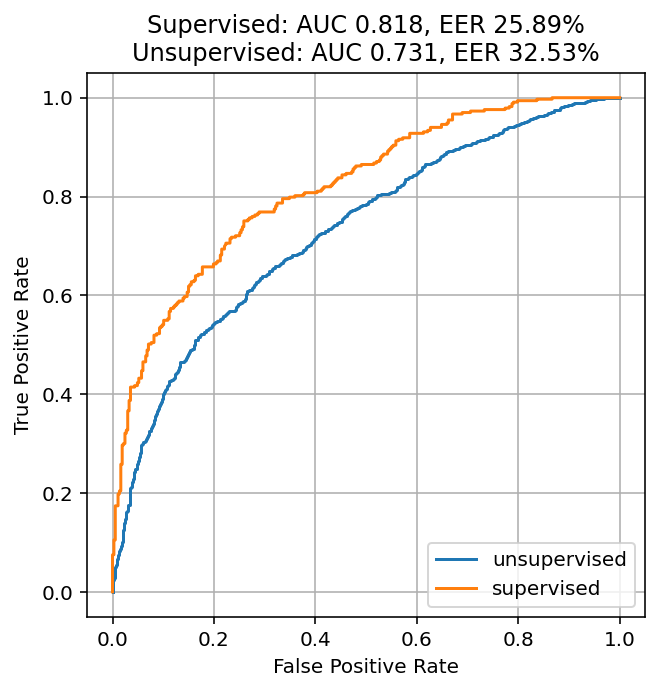

In [34]:
plt.figure(figsize=(5,5))
plt.plot(fprU, tprU, label="unsupervised")
plt.plot(fpr, tpr, label="supervised")
plt.grid('minor')
plt.title("Supervised: AUC {:.3f}, EER 25.89%\nUnsupervised: AUC {:.3f}, EER 32.53%".format(auc, aucU))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig("binary-roc.pdf", bbox_inches='tight')
plt.legend(loc=4)
plt.savefig("sig_roc.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

### EER

In [ ]:
fpr, tpr, threshold = roc_curve(X[1], X[2], pos_label=1)
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
EER

## Run ELM Optimization

ELM itself can run on my laptop, and evaluate all results on the laptop.

ELM *Optimization* is what runs in the cloud - it gathers statistics of many many ELM trials with different random combinations of parameters. Tighter parameter ranges and good combinations are dsicovered through this random search process, iteration by iteration.

In [ ]:
params = {
    'alpha': loguniform(1e-2, 1e+2),
    'ufunc': ['tanh', 'sigm', 'relu', 'lin'],
    'pairwise_metric': [None, 'euclidean', 'cityblock', 'cosine'],
    'density': loguniform(0.001, 1),
    'n_neurons': loguniform(10, 10000),
}

In [ ]:
rcv = RandomizedSearchCV(
    skelm.ELMClassifier(), params, n_iter=4, scoring='accuracy', cv=3, refit=False,
    verbose=3, n_jobs=None, return_train_score=True
)
rcv.fit(x, y)

In [ ]:
pd.DataFrame(rcv.cv_results_)

## actually run the ELM...

In [ ]:
rcv = RandomizedSearchCV(skelm.ELMClassifier(), params, n_iter=100, scoring='accuracy', cv=3, refit=False)
rcv.fit(x, y)

In [ ]:
for i in range(2, 5):  #100000
    rcv = RandomizedSearchCV(skelm.ELMClassifier(), params, n_iter=100, scoring='accuracy', cv=3, refit=False)
    res = rcv.fit(x, y)
    pd.DataFrame(res.cv_results_).to_pickle("res_v2/res_v2_{}.pkl".format(i))

## 

## Check results

In [ ]:
Z = pd.concat((pd.read_pickle("res_v2/res_v2_{}.pkl".format(i)) for i in range(9999) if os.path.isfile("res_v2/res_v2_{}.pkl".format(i))))
Z = Z.reset_index(drop=True)
Z = Z.drop(["params", "param_pairwise_metric", "param_ufunc"] , axis=1)

Z['param_n_neurons'] = Z['param_n_neurons'].apply(lambda a : a // 50 * 50)
Z['param_density'] = Z['param_density'].apply(lambda a : (a + 0.05)//0.1 * 0.1)
Z['param_alpha'] = Z['param_alpha'].apply(lambda a : np.log10(a)//0.5 * 0.5)

In [ ]:
plt.figure(figsize=(8, 10))
P_10k = pd.pivot_table(Z, index='param_n_neurons', columns='param_alpha', values="mean_test_score")
# sn.heatmap(P, vmin=0.61)

In [ ]:
fname0 = "res_v2/res_v2_{}_n100000.pkl"
Z = pd.concat((pd.read_pickle(fname0.format(i)) for i in range(9999) if os.path.isfile(fname0.format(i))))
Z = Z.reset_index(drop=True)
Z = Z.drop(["params", "param_pairwise_metric", "param_ufunc"] , axis=1)

Z['param_n_neurons'] = Z['param_n_neurons'].apply(lambda a : a // 50 * 50)
Z['param_density'] = Z['param_density'].apply(lambda a : (a + 0.05)//0.1 * 0.1)
Z['param_alpha'] = Z['param_alpha'].apply(lambda a : np.log10(a)//0.5 * 0.5)

In [ ]:
plt.figure(figsize=(8, 10))
P = pd.pivot_table(Z, index='param_n_neurons', columns='param_alpha', values="mean_test_score")
sn.heatmap(P, vmin=0.64)

## performance vs number of training samples, best model

In [ ]:
train_idx, test_idx = next(GroupShuffleSplit().split(x, y, groups))
xt, xs, yt, ys = x[train_idx], x[test_idx], y[train_idx], y[test_idx]

In [ ]:
data = []
model = skelm.ELMClassifier(n_neurons=2000, alpha=0.3, batch_size=5000)

for j in np.logspace(3, np.log10(xt.shape[0]), num=30):
    jj = int(j)
    print(jj, end=' ... ')
    t = time()
    score = model.fit(x[:jj], y[:jj]).score(xs, ys)
    data.append({'N': j, 'score': score})
    t = time() - t
    print("{:.3f} : {:.1f}s".format(score, t))

In [ ]:
Z = pd.DataFrame(data)
Z.plot(x='N', y='score', logx=True, figsize=(15, 7), grid=True)

In [ ]:
data = []
model = skelm.ELMClassifier(n_neurons=2000, alpha=0.3, batch_size=5000)

for j in np.logspace(3, np.log10(xt.shape[0]), num=30):
    jj = int(j)
    print(jj, end=' ... ')
    t = time()
    score = model.fit(x[:jj], y[:jj]).score(xs, ys)
    data.append({'N': j, 'score': score})
    t = time() - t
    print("{:.3f} : {:.1f}s".format(score, t))

In [ ]:
Z = pd.DataFrame(data)
Z.plot(x='N', y='score', logx=True, figsize=(15, 7), grid=True)

#  

## Tune best parameters for limited-sample models

In [ ]:
Ns = [4110, 5700, 10890]
Ns = [int(n * (30/27) * (3/2)) for n in Ns]

In [ ]:
params = {
    'alpha': loguniform(1e+1, 1e+4),
    'n_neurons': loguniform(2000, 10000),
}

In [ ]:
for i in range(1, 500):
    for n1, res in zip(Ns, (res1, res2, res3)):
        rcv = RandomizedSearchCV(skelm.ELMClassifier(batch_size=10000), params, n_iter=20, scoring='accuracy', cv=3, refit=False)
        res.append(pd.DataFrame(rcv.fit(x[:n1], y[:n1]).cv_results_))
        print("{}:{}".format(i, n1//1000), end=' ')

In [ ]:
import pickle

In [ ]:
with open("res123_current.pkl", "wb") as fr:
    pickle.dump({"res1": res1, "res2": res2, "res3":res3}, fr)

In [ ]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(18, 8))#, gridspec_kw={'hspace': 0, 'wspace': 0.3})
fig.suptitle('Horizontally stacked subplots')

k = 0
for res, ax in zip([res1, res2, res3], axes):
    k += 1
    Z = pd.concat(res)
    Z['neurons'] = Z['param_n_neurons'].apply(lambda a : 2 ** (np.log2(a) // 0.15 * 0.15)).astype(int)
    Z['alpha'] = Z['param_alpha'].apply(lambda a : np.log10(a)//0.2 * 0.2).apply(lambda a: np.round(a, 1))
    P = pd.pivot_table(Z, index='neurons', columns='alpha', values="mean_test_score")
    sn.heatmap(P, ax=ax, square=True, cbar=False, vmin=0.6)
    ax.set_title([4110, 5700, 10890][k-1])

In [ ]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(18, 8))#, gridspec_kw={'hspace': 0, 'wspace': 0.3})
fig.suptitle('Horizontally stacked subplots')

k = 0
for res, ax in zip([res1, res2, res3], axes):
    k += 1
    Z = pd.concat(res)
    Z['neurons'] = Z['param_n_neurons'].apply(lambda a : 2 ** (np.log2(a) // 0.15 * 0.15)).astype(int)
    Z['alpha'] = Z['param_alpha'].apply(lambda a : np.log10(a)//0.2 * 0.2).apply(lambda a: np.round(a, 1))
    P = pd.pivot_table(Z[(Z.alpha > 0.5) & (Z.alpha < 4.1) & (Z.neurons > 500)], 
                       index='neurons', columns='alpha', values="mean_test_score")
    sn.heatmap(P, ax=ax, square=True, cbar=False, vmin=0.6)
    ax.set_title([4110, 5700, 10890][k-1])

In [ ]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 8))#, gridspec_kw={'hspace': 0, 'wspace': 0.3})
fig.suptitle('Horizontally stacked subplots')

k = 0
for res, ax in zip([res1, res2, res3], axes):
    k += 1
    Z = pd.concat(res)
    Z['neurons'] = Z['param_n_neurons'].apply(lambda a : a // 100 * 100).astype(np.int)
    Z['alpha'] = Z['param_alpha'].apply(lambda a : np.log10(a)//0.5 * 0.5)
    P = pd.pivot_table(Z, index='neurons', columns='alpha', values="mean_test_score")
    sn.heatmap(P, ax=ax, square=False, cbar=k==3)

#  

## Final experiments

In [ ]:
X = pd.read_pickle("/home/akusok/HDD2TB/MCYTD_10p_n100.pkl")

In [ ]:
Z = pd.concat((
    pd.get_dummies(X.uid, prefix='user'),
    X.drop(['wsize', 'overlap', 'xmin', 'ymin', 'xmax', 'ymax', 'uid'], axis=1)
), axis=1)

In [ ]:
Z.loc[:, '0':'1023'] = Z.loc[:, '0':'1023'] - Z.loc[:, '0':'1023'].mean()

In [ ]:
# clip low standard deviation to avoid excessively large numbers
Z.loc[:, '0':'1023'] = Z.loc[:, '0':'1023'] / Z.loc[:, '0':'1023'].std().clip(lower=0.5)

In [ ]:
# limit the value range
Z.loc[:, '0':'1023'] = Z.loc[:, '0':'1023'].clip(lower=-5.0, upper=5.0)

In [ ]:
Z = Z.reset_index(drop=True)

In [ ]:
y = np.array(Z.sig_true)
x = np.array(Z.drop(['sig_true', 'fid'], axis=1))
groups = Z.fid

In [ ]:
from sklearn.model_selection import cross_val_predict

In [ ]:
model = skelm.ELMClassifier(alpha=10, n_neurons=1000, ufunc='sigm', density=0.02)

In [ ]:
cvp = cross_val_predict(model, x, y, groups=groups, cv=GroupKFold(n_splits=10), n_jobs=3, pre_dispatch=3)

In [ ]:
np.save("/home/akusok/HDD2TB/MCYTD_10p_n100-predict.npy", cvp)